In [1]:
# Cell 1: Setup + palette
from pathlib import Path
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as mtick

BASE_DIR = Path("/Users/zacharylevitan/Documents/School_Code_Stuff/Arizona/SABR26")
SIM_DIR = BASE_DIR / "Simulations" / "output"
DATA_DIR = BASE_DIR / "Data"
OUT_DIR = SIM_DIR / "decision_framework"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Required colors
CLR_LOW  = "#d73027"  # red = bad
CLR_MID  = "#ffffbf"  # yellow = neutral
CLR_HIGH = "#1a9850"  # green = good
CMAP_RYG = LinearSegmentedColormap.from_list("ryg_custom", [CLR_LOW, CLR_MID, CLR_HIGH])

# Force only 2024-2025 data
PBP_FILES = [DATA_DIR / "pbp_2024.parquet", DATA_DIR / "pbp_2025.parquet"]
PBP_FILES = [f for f in PBP_FILES if f.exists()]
if len(PBP_FILES) != 2:
    raise FileNotFoundError("Need both pbp_2024.parquet and pbp_2025.parquet in Data/")


In [2]:
# Cell 1.5: Load names correctly
import unicodedata

# Canonical display names (with accents)
CANONICAL_NAMES = {
    "oneil cruz": "Oneil Cruz",
    "james wood": "James Wood",
    "ryan mcmahon": "Ryan McMahon",
    "riley greene": "Riley Greene",
    "eugenio suarez": "Eugenio Suárez",
    "elly de la cruz": "Elly De La Cruz",
    "kyle schwarber": "Kyle Schwarber",
    "jo adell": "Jo Adell",
    "teoscar hernandez": "Teoscar Hernández",
    "spencer torkelson": "Spencer Torkelson",
    "lawrence butler": "Lawrence Butler",
    "randy arozarena": "Randy Arozarena",
    "adolis garcia": "Adolis García",
    "jazz chisholm jr": "Jazz Chisholm Jr.",
    "christian walker": "Christian Walker",
    "michael busch": "Michael Busch",
    "willy adames": "Willy Adames",
    "taylor ward": "Taylor Ward",
    "rafael devers": "Rafael Devers",
    "brent rooker": "Brent Rooker",
    "zach neto": "Zach Neto",
    "matt olson": "Matt Olson",
    "marcell ozuna": "Marcell Ozuna",
    "ian happ": "Ian Happ",
    "pete crow armstrong": "Pete Crow-Armstrong",
    "pete alonso": "Pete Alonso",
    "shea langeliers": "Shea Langeliers",
}

def norm_name(s: str) -> str:
    if pd.isna(s):
        return ""
    s = str(s).strip().lower()
    s = unicodedata.normalize("NFKD", s)
    s = "".join(ch for ch in s if not unicodedata.combining(ch))  # removes accents for matching
    s = s.replace(".", "").replace("-", " ")
    s = " ".join(s.split())
    return s

def canonicalize_name(s: str) -> str:
    n = norm_name(s)
    return CANONICAL_NAMES.get(n, s)


In [3]:
# Cell 2: Load existing simulation data only (no rerun)
parquet_files = sorted(SIM_DIR.glob("*_simulation.parquet"))
csv_fallback = SIM_DIR / "sim_from_python.csv"

if parquet_files:
    sim = pd.concat([pd.read_parquet(f) for f in parquet_files], ignore_index=True)
    print(f"Loaded {len(parquet_files)} parquet files, rows={len(sim):,}")
elif csv_fallback.exists():
    sim = pd.read_csv(csv_fallback)
    print(f"Loaded {csv_fallback.name}, rows={len(sim):,}")
else:
    raise FileNotFoundError(f"No simulation files found in {SIM_DIR}")

required_sim = [
    "player_name","bat_speed_change_pct","swing_length_change_pct","pitcher_xfip_percentile",
    "count","outs","base_state","inning","inning_topbot","score_diff","wp_diff_from_baseline",
    "prob_K","prob_BB_HBP","prob_field_out","prob_1B","prob_2B","prob_3B","prob_HR"
]
missing = [c for c in required_sim if c not in sim.columns]
if missing:
    raise ValueError(f"Simulation missing columns: {missing}")


Loaded 27 parquet files, rows=40,824,000


In [4]:
# Cell 2.5: Feasibility Check
if "is_feasible" not in sim.columns:
    raise ValueError("Expected column 'is_feasible' not found in simulation data.")

sim["is_feasible"] = pd.to_numeric(sim["is_feasible"], errors="coerce").fillna(0).astype(int)
sim = sim[sim["is_feasible"] == 1].copy()

print("Rows after feasible filter:", len(sim))


Rows after feasible filter: 33929280


In [5]:
# Cell 3: Build lookup (memory-safe, 2024-2025 only) + robust score_diff derivation
def map_outcome(ev):
    if ev in {"strikeout", "strikeout_double_play"}: return "K"
    if ev in {"walk", "intent_walk", "hit_by_pitch"}: return "BB_HBP"
    if ev == "single": return "1B"
    if ev == "double": return "2B"
    if ev == "triple": return "3B"
    if ev == "home_run": return "HR"
    if ev in {
        "field_out","force_out","double_play","fielders_choice","fielders_choice_out",
        "grounded_into_double_play","sac_fly","sac_bunt","sac_fly_double_play",
        "triple_play","sac_bunt_double_play"
    }: return "field_out"
    return None

def add_score_diff(df):
    if "score_diff" in df.columns:
        df["score_diff"] = pd.to_numeric(df["score_diff"], errors="coerce")
        return df

    if {"bat_score","fld_score"}.issubset(df.columns):
        df["score_diff"] = pd.to_numeric(df["bat_score"], errors="coerce") - pd.to_numeric(df["fld_score"], errors="coerce")
        return df

    if {"home_score","away_score","inning_topbot"}.issubset(df.columns):
        hs = pd.to_numeric(df["home_score"], errors="coerce")
        aw = pd.to_numeric(df["away_score"], errors="coerce")
        top = df["inning_topbot"].astype(str).str.lower().str.startswith("top")
        bat = np.where(top, aw, hs)
        fld = np.where(top, hs, aw)
        df["score_diff"] = bat - fld
        return df

    if {"bat_score","home_score","away_score","inning_topbot"}.issubset(df.columns):
        bat = pd.to_numeric(df["bat_score"], errors="coerce")
        hs = pd.to_numeric(df["home_score"], errors="coerce")
        aw = pd.to_numeric(df["away_score"], errors="coerce")
        top = df["inning_topbot"].astype(str).str.lower().str.startswith("top")
        fld = np.where(top, hs, aw)
        df["score_diff"] = bat - fld
        return df

    raise ValueError(f"Cannot derive score_diff. Columns in file include: {sorted(df.columns.tolist())[:60]} ...")

lookup_chunks = []
outcome_chunks = []

for f in PBP_FILES:
    print("Reading", f.name)
    # Read full file once (safer with unknown column layout)
    df = pd.read_parquet(f)
    df = add_score_diff(df)

    needed = ["events","balls","strikes","outs_when_up","on_1b","on_2b","on_3b",
              "inning","inning_topbot","bat_score","post_bat_score","score_diff"]
    miss = [c for c in needed if c not in df.columns]
    if miss:
        raise ValueError(f"{f.name} missing columns after load: {miss}")

    df = df[df["events"].notna() & (df["events"] != "")].copy()
    df["outcome"] = df["events"].map(map_outcome)
    df = df[df["outcome"].notna()].copy()

    df["count"] = df["balls"].astype(str) + "-" + df["strikes"].astype(str)
    df["outs"] = pd.to_numeric(df["outs_when_up"], errors="coerce").astype("Int64")
    df["base_state"] = (
        df["on_1b"].notna().astype(int)
        + 2 * df["on_2b"].notna().astype(int)
        + 4 * df["on_3b"].notna().astype(int)
    ).astype(int)
    df["runs_scored"] = (pd.to_numeric(df["post_bat_score"], errors="coerce") - pd.to_numeric(df["bat_score"], errors="coerce")).clip(lower=0)

    df = df[
        df["outs"].isin([0,1,2]) &
        df["inning"].between(7,9) &
        pd.to_numeric(df["score_diff"], errors="coerce").between(-4,2)
    ].copy()

    g = (
        df.groupby(["count","outs","base_state","inning","inning_topbot","score_diff","outcome"], as_index=False)
          .agg(
              n=("runs_scored","size"),
              one_run=("runs_scored", lambda x: (x == 1).sum()),
              sum_runs=("runs_scored","sum")
          )
    )
    lookup_chunks.append(g)

    go = df.groupby("outcome", as_index=False).agg(
        n=("runs_scored","size"),
        sum_runs=("runs_scored","sum")
    )
    outcome_chunks.append(go)

    del df, g, go
    gc.collect()

lookup_raw = pd.concat(lookup_chunks, ignore_index=True)
lookup_raw = (
    lookup_raw.groupby(["count","outs","base_state","inning","inning_topbot","score_diff","outcome"], as_index=False)
    .agg(n=("n","sum"), one_run=("one_run","sum"), sum_runs=("sum_runs","sum"))
)
lookup_raw["mean_runs"] = lookup_raw["sum_runs"] / lookup_raw["n"]

global_raw = pd.concat(outcome_chunks, ignore_index=True)
global_raw = global_raw.groupby("outcome", as_index=False).agg(n=("n","sum"), sum_runs=("sum_runs","sum"))
global_raw["g_erv"] = global_raw["sum_runs"] / global_raw["n"]

lookup = lookup_raw.merge(global_raw[["outcome","g_erv"]], on="outcome", how="left")
lookup["p1"] = (lookup["one_run"] + 1) / (lookup["n"] + 2)
lookup["erv"] = (lookup["n"] * lookup["mean_runs"] + 50 * lookup["g_erv"]) / (lookup["n"] + 50)
lookup = lookup[["count","outs","base_state","inning","inning_topbot","score_diff","outcome","p1","erv"]]

print("lookup rows:", len(lookup))


Reading pbp_2024.parquet
Reading pbp_2025.parquet
lookup rows: 18696


In [6]:
# Cell 4 (memory-safe): compute DeltaWP / DeltaP1 / DeltaERV without melt
import gc

state_keys = ["count","outs","base_state","inning","inning_topbot","score_diff"]

# 1) Build wide lookup: one row per state, p1_* and erv_* columns
lk = lookup.copy()
lk["p1_col"] = "p1_" + lk["outcome"].astype(str)
lk["erv_col"] = "erv_" + lk["outcome"].astype(str)

p1_wide = lk.pivot_table(index=state_keys, columns="p1_col", values="p1", aggfunc="mean").reset_index()
erv_wide = lk.pivot_table(index=state_keys, columns="erv_col", values="erv", aggfunc="mean").reset_index()

lookup_wide = p1_wide.merge(erv_wide, on=state_keys, how="outer")

# 2) Keep only needed sim cols and cast down types
keep_cols = [
    "player_name","bat_speed_change_pct","swing_length_change_pct","pitcher_xfip_percentile",
    "count","outs","base_state","inning","inning_topbot","score_diff","wp_diff_from_baseline",
    "prob_K","prob_BB_HBP","prob_field_out","prob_1B","prob_2B","prob_3B","prob_HR"
]
sim_small = sim[keep_cols].copy()

num_cols = [
    "bat_speed_change_pct","swing_length_change_pct","pitcher_xfip_percentile",
    "outs","base_state","inning","score_diff","wp_diff_from_baseline",
    "prob_K","prob_BB_HBP","prob_field_out","prob_1B","prob_2B","prob_3B","prob_HR"
]
for c in num_cols:
    sim_small[c] = pd.to_numeric(sim_small[c], errors="coerce").astype("float32")

# 3) Merge state lookup once
df = sim_small.merge(lookup_wide, on=state_keys, how="left")

# Fill missing lookup values with 0
for c in ["p1_K","p1_BB_HBP","p1_field_out","p1_1B","p1_2B","p1_3B","p1_HR",
          "erv_K","erv_BB_HBP","erv_field_out","erv_1B","erv_2B","erv_3B","erv_HR"]:
    if c not in df.columns:
        df[c] = 0.0
    df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0.0).astype("float32")

# 4) Row-wise expected values (dot products)
df["exp_p1"] = (
    df["prob_K"] * df["p1_K"] +
    df["prob_BB_HBP"] * df["p1_BB_HBP"] +
    df["prob_field_out"] * df["p1_field_out"] +
    df["prob_1B"] * df["p1_1B"] +
    df["prob_2B"] * df["p1_2B"] +
    df["prob_3B"] * df["p1_3B"] +
    df["prob_HR"] * df["p1_HR"]
).astype("float32")

df["exp_erv"] = (
    df["prob_K"] * df["erv_K"] +
    df["prob_BB_HBP"] * df["erv_BB_HBP"] +
    df["prob_field_out"] * df["erv_field_out"] +
    df["prob_1B"] * df["erv_1B"] +
    df["prob_2B"] * df["erv_2B"] +
    df["prob_3B"] * df["erv_3B"] +
    df["prob_HR"] * df["erv_HR"]
).astype("float32")

# 5) Baseline join to get deltas
base_cols = [
    "player_name","pitcher_xfip_percentile","count","outs","base_state","inning","inning_topbot","score_diff"
]
baseline = df[
    (df["bat_speed_change_pct"] == 0) & (df["swing_length_change_pct"] == 0)
][base_cols + ["exp_p1","exp_erv"]].rename(columns={"exp_p1":"base_exp_p1","exp_erv":"base_exp_erv"})

decision_df = df.merge(baseline, on=base_cols, how="left")
decision_df["delta_wp"] = decision_df["wp_diff_from_baseline"]
decision_df["delta_p1"] = decision_df["exp_p1"] - decision_df["base_exp_p1"]
decision_df["delta_erv"] = decision_df["exp_erv"] - decision_df["base_exp_erv"]
decision_df["wca_better"] = decision_df["delta_wp"] > 0

# Keep output lean
decision_keep = base_cols + [
    "player_name","bat_speed_change_pct","swing_length_change_pct","pitcher_xfip_percentile",
    "wp_diff_from_baseline","exp_p1","exp_erv","base_exp_p1","base_exp_erv",
    "delta_wp","delta_p1","delta_erv","wca_better"
]
decision_df = decision_df[[c for c in decision_keep if c in decision_df.columns]].copy()

decision_df.to_csv(OUT_DIR / "decision_metrics_detailed.csv", index=False)
print("decision rows:", len(decision_df))

del sim_small, p1_wide, erv_wide, lookup_wide, df, baseline
gc.collect()


decision rows: 33929280


0

In [7]:
# Cell 4.1: Insure canonical names
sim["player_name"] = sim["player_name"].map(canonicalize_name)

In [8]:
# Cell 4.5: Fix duplicate columns in decision_df
print("Duplicate cols:", decision_df.columns[decision_df.columns.duplicated()].tolist())

decision_df = decision_df.loc[:, ~decision_df.columns.duplicated()].copy()

# optional sanity check
assert decision_df.columns.duplicated().sum() == 0
print("Duplicates removed. shape:", decision_df.shape)


Duplicate cols: ['player_name', 'pitcher_xfip_percentile']
Duplicates removed. shape: (33929280, 19)


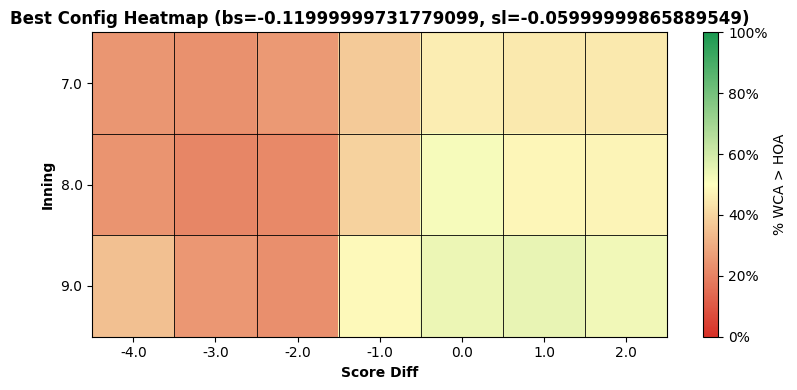

In [20]:
# Cell 5: State summaries + heatmap (green good, red bad) with dividing lines
state_tax = decision_df.copy()

state_tax["leverage_bucket"] = np.where(
    (state_tax["inning"] == 9) & (state_tax["score_diff"].abs() <= 1), "9th_close",
    np.where((state_tax["inning"] >= 8) & (state_tax["score_diff"].abs() <= 1), "8th_9th_close", "other")
)

state_tax["one_run_pressure"] = np.where(
    state_tax["base_state"].isin([4,5,6,7]) & (state_tax["outs"] <= 1), "R3_or_better_<=1_out",
    np.where(state_tax["base_state"].isin([2,3,6,7]) & (state_tax["outs"] <= 1), "RISP_<=1_out", "other")
)

state_summary = (
    state_tax.groupby(
        ["leverage_bucket","one_run_pressure","pitcher_xfip_percentile","bat_speed_change_pct","swing_length_change_pct"],
        as_index=False
    )
    .agg(
        avg_delta_wp=("delta_wp","mean"),
        avg_delta_p1=("delta_p1","mean"),
        avg_delta_erv=("delta_erv","mean"),
        pct_states_wca_better=("wca_better","mean"),
        n=("wca_better","size")
    )
    .sort_values("avg_delta_wp", ascending=False)
)
state_summary.to_csv(OUT_DIR / "state_taxonomy_summary.csv", index=False)

hm = state_tax[(state_tax["bat_speed_change_pct"] != 0) | (state_tax["swing_length_change_pct"] != 0)].copy()
hm = hm.groupby(["inning","score_diff","bat_speed_change_pct","swing_length_change_pct"], as_index=False).agg(
    pct_wca_better=("wca_better","mean")
)

best_cfg = (
    hm.groupby(["bat_speed_change_pct","swing_length_change_pct"], as_index=False)["pct_wca_better"]
      .mean()
      .sort_values("pct_wca_better", ascending=False)
      .iloc[0]
)

sub = hm[
    (hm["bat_speed_change_pct"] == best_cfg["bat_speed_change_pct"]) &
    (hm["swing_length_change_pct"] == best_cfg["swing_length_change_pct"])
].pivot(index="inning", columns="score_diff", values="pct_wca_better").sort_index()

fig, ax = plt.subplots(figsize=(8,4))
im = ax.imshow(sub.values, aspect="auto", cmap=CMAP_RYG, vmin=0, vmax=1)

ax.set_xticks(range(len(sub.columns)))
ax.set_xticklabels(sub.columns)
ax.set_yticks(range(len(sub.index)))
ax.set_yticklabels(sub.index)

# Add cell dividing lines
ax.set_xticks(np.arange(-0.5, sub.shape[1], 1), minor=True)
ax.set_yticks(np.arange(-0.5, sub.shape[0], 1), minor=True)
ax.grid(which="minor", color="black", linestyle="-", linewidth=0.6)
ax.tick_params(which="minor", bottom=False, left=False)

cbar = plt.colorbar(im, ax=ax, label="% WCA > HOA")
cbar.ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

ax.set_title(
    f"Best Config Heatmap (bs={best_cfg['bat_speed_change_pct']}, sl={best_cfg['swing_length_change_pct']})",
    fontweight="bold"
)
ax.set_xlabel("Score Diff", fontweight="bold")
ax.set_ylabel("Inning", fontweight="bold")

plt.tight_layout()
plt.savefig(OUT_DIR / "heatmap_wca_beats_hoa.png", dpi=300)
plt.show()


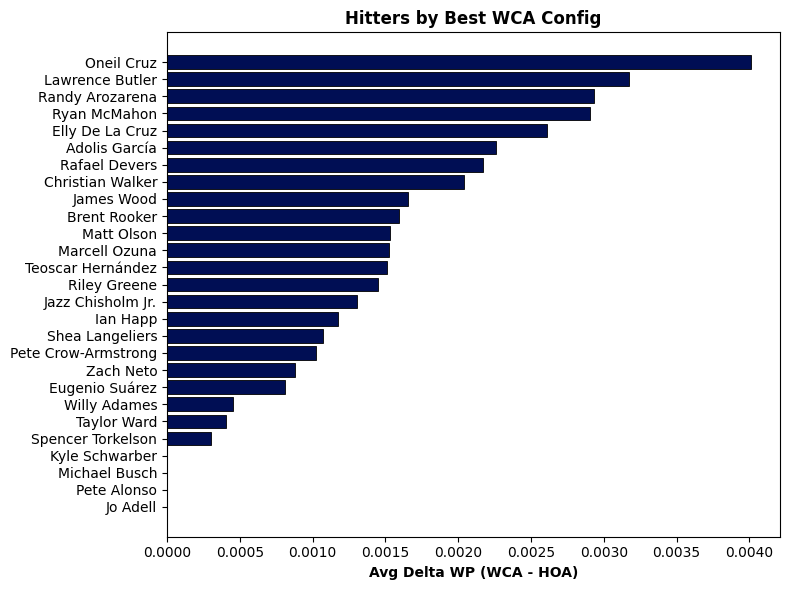

In [22]:
# Cell 6: Hitter rankings
rank_df = state_tax[
    (state_tax["inning"] >= 8) &
    (state_tax["score_diff"].abs() <= 1) &
    (state_tax["base_state"].isin([2,3,4,5,6,7]))
].copy()

hitter_rank_all = (
    rank_df.groupby(["player_name","bat_speed_change_pct","swing_length_change_pct"], as_index=False)
      .agg(
          avg_delta_wp=("delta_wp","mean"),
          avg_delta_p1=("delta_p1","mean"),
          avg_delta_erv=("delta_erv","mean"),
          pct_states_wca_better=("wca_better","mean"),
          n=("wca_better","size")
      )
      .sort_values("avg_delta_wp", ascending=False)
)

best_cfg_per_hitter = (
    hitter_rank_all.sort_values("avg_delta_wp", ascending=False)
    .groupby("player_name", as_index=False)
    .head(1)
    .sort_values("avg_delta_wp", ascending=False)
)

hitter_rank_all.to_csv(OUT_DIR / "hitter_rank_all_configs.csv", index=False)
best_cfg_per_hitter.to_csv(OUT_DIR / "hitter_rank_best_config.csv", index=False)

hitters = best_cfg_per_hitter.head(27).sort_values("avg_delta_wp")
plt.figure(figsize=(8,6))
plt.barh(
    hitters["player_name"],
    hitters["avg_delta_wp"],
    color="#000E54",
    edgecolor="black",
    linewidth=0.6
)
plt.title("Hitters by Best WCA Config", fontweight="bold")
plt.xlabel("Avg Delta WP (WCA - HOA)", fontweight="bold")
plt.tight_layout()
plt.savefig(OUT_DIR / "hitter_delta_wp.png", dpi=300)
plt.show()

In [11]:
# Cell 7: Adjustability for 27 players with accented names + ID/name fallback matching
import unicodedata
import gc
import numpy as np
import pandas as pd

PVC_27_CANON = [
    "Oneil Cruz","James Wood","Ryan McMahon","Riley Greene","Eugenio Suárez","Elly De La Cruz",
    "Kyle Schwarber","Jo Adell","Teoscar Hernández","Spencer Torkelson","Lawrence Butler",
    "Randy Arozarena","Adolis García","Jazz Chisholm Jr.","Christian Walker","Michael Busch",
    "Willy Adames","Taylor Ward","Rafael Devers","Brent Rooker","Zach Neto","Matt Olson",
    "Marcell Ozuna","Ian Happ","Pete Crow-Armstrong","Pete Alonso","Shea Langeliers"
]

def norm_name(s):
    if pd.isna(s): return ""
    s = str(s).strip()
    try:
        s = s.encode("latin1").decode("utf-8")
    except Exception:
        pass
    s = s.lower()
    s = unicodedata.normalize("NFKD", s)
    s = "".join(ch for ch in s if not unicodedata.combining(ch))
    s = s.replace(".", "").replace("-", " ")
    s = " ".join(s.split())
    return s

canon_map = {norm_name(n): n for n in PVC_27_CANON}

# Build id -> canonical name map from sim
if "batter_id" not in sim.columns or "player_name" not in sim.columns:
    raise ValueError("sim must contain batter_id and player_name")

id_map = (
    sim[["batter_id","player_name"]]
    .dropna(subset=["batter_id"])
    .drop_duplicates()
    .copy()
)
id_map["batter_id"] = pd.to_numeric(id_map["batter_id"], errors="coerce").astype("Int64")
id_map["player_name"] = id_map["player_name"].map(lambda x: canon_map.get(norm_name(x), x))
id_map = id_map[id_map["player_name"].isin(PVC_27_CANON)].drop_duplicates(subset=["batter_id"])

id_to_name = dict(zip(id_map["batter_id"].astype("Int64"), id_map["player_name"]))
print("ID map rows:", len(id_map), "| unique players:", id_map["player_name"].nunique())

# Ensure add_score_diff exists
if "add_score_diff" not in globals():
    def add_score_diff(df):
        if "score_diff" in df.columns:
            df["score_diff"] = pd.to_numeric(df["score_diff"], errors="coerce")
            return df
        if {"bat_score","fld_score"}.issubset(df.columns):
            df["score_diff"] = pd.to_numeric(df["bat_score"], errors="coerce") - pd.to_numeric(df["fld_score"], errors="coerce")
            return df
        if {"home_score","away_score","inning_topbot"}.issubset(df.columns):
            hs = pd.to_numeric(df["home_score"], errors="coerce")
            aw = pd.to_numeric(df["away_score"], errors="coerce")
            top = df["inning_topbot"].astype(str).str.lower().str.startswith("top")
            bat = np.where(top, aw, hs)
            fld = np.where(top, hs, aw)
            df["score_diff"] = bat - fld
            return df
        if {"bat_score","home_score","away_score","inning_topbot"}.issubset(df.columns):
            bat = pd.to_numeric(df["bat_score"], errors="coerce")
            hs = pd.to_numeric(df["home_score"], errors="coerce")
            aw = pd.to_numeric(df["away_score"], errors="coerce")
            top = df["inning_topbot"].astype(str).str.lower().str.startswith("top")
            fld = np.where(top, hs, aw)
            df["score_diff"] = bat - fld
            return df
        raise ValueError("Cannot derive score_diff.")

def find_batter_id_col(cols):
    for c in ["batter","batter_id","batterId","batterID","batterid"]:
        if c in cols:
            return c
    low = {c.lower(): c for c in cols}
    for c in ["batter","batter_id","batterid"]:
        if c in low:
            return low[c]
    return None

swing_desc = {
    "swinging_strike","swinging_strike_blocked","foul","foul_tip",
    "hit_into_play","hit_into_play_no_out","hit_into_play_score"
}
contact_desc = {"foul","foul_tip","hit_into_play","hit_into_play_no_out","hit_into_play_score"}

chunks = []
for f in PBP_FILES:
    print("\nReading", f.name)
    df = pd.read_parquet(f)
    df = add_score_diff(df)

    need = ["description","zone","inning","score_diff"]
    miss = [c for c in need if c not in df.columns]
    if miss:
        raise ValueError(f"{f.name} missing required columns: {miss}")

    before = len(df)
    df = df[df["description"].notna() & df["zone"].notna()].copy()
    after_basic = len(df)

    matched = pd.DataFrame()

    # ID-based selection (primary)
    id_col = find_batter_id_col(df.columns)
    if id_col is not None:
        df["_batter_id"] = pd.to_numeric(df[id_col], errors="coerce").astype("Int64")
        df["player_name"] = df["_batter_id"].map(id_to_name)  # direct map, no merge suffixes
        matched = df[df["player_name"].notna()].copy()

    # Name fallback only if no ID match
    if matched.empty and "batter_name" in df.columns:
        df["_name_norm"] = df["batter_name"].map(norm_name)
        df["player_name"] = df["_name_norm"].map(canon_map)
        matched = df[df["player_name"].notna()].copy()

    if matched.empty:
        print(f"{f.name}: before={before:,}, after_basic={after_basic:,}, matched=0, id_col={id_col}")
        del df
        gc.collect()
        continue

    # safety: keep only cohort names
    matched = matched[matched["player_name"].isin(PVC_27_CANON)].copy()

    matched["leverage"] = np.where(
        (pd.to_numeric(matched["inning"], errors="coerce") >= 8) &
        (pd.to_numeric(matched["score_diff"], errors="coerce").abs() <= 1),
        "high", "low"
    )
    matched["is_swing"] = matched["description"].isin(swing_desc)
    matched["is_contact"] = matched["description"].isin(contact_desc)
    matched["in_zone"] = matched["zone"].isin(range(1,10))
    matched["out_zone"] = ~matched["in_zone"]

    matched["is_swing_out"] = matched["is_swing"] & matched["out_zone"]
    matched["is_swing_in"] = matched["is_swing"] & matched["in_zone"]
    matched["is_contact_in"] = matched["is_contact"] & matched["in_zone"]

    g = matched.groupby(["player_name","leverage"], as_index=False).agg(
        pitches=("description","size"),
        swings=("is_swing","sum"),
        contacts=("is_contact","sum"),
        out_zone_pitches=("out_zone","sum"),
        out_zone_swings=("is_swing_out","sum"),
        in_zone_swings=("is_swing_in","sum"),
        in_zone_contacts=("is_contact_in","sum"),
    )
    chunks.append(g)

    print(f"{f.name}: before={before:,}, after_basic={after_basic:,}, matched={len(matched):,}, grouped={len(g):,}, id_col={id_col}")
    del df, matched, g
    gc.collect()

if not chunks:
    raise ValueError("No adjustability rows produced.")

adj_raw = pd.concat(chunks, ignore_index=True)
adj_raw = adj_raw.groupby(["player_name","leverage"], as_index=False).sum(numeric_only=True)

# grouped should be <= 54 (27 players x 2 leverage buckets)
print("unique player_name in adj_raw:", adj_raw["player_name"].nunique())

adj_raw["contact_rate"] = np.where(adj_raw["swings"] > 0, adj_raw["contacts"] / adj_raw["swings"], np.nan)
adj_raw["o_swing"] = np.where(adj_raw["out_zone_pitches"] > 0, adj_raw["out_zone_swings"] / adj_raw["out_zone_pitches"], np.nan)
adj_raw["z_contact"] = np.where(adj_raw["in_zone_swings"] > 0, adj_raw["in_zone_contacts"] / adj_raw["in_zone_swings"], np.nan)

wide = adj_raw.pivot(index="player_name", columns="leverage")
wide.columns = [f"{a}_{b}" for a, b in wide.columns]
wide = wide.reset_index()

for c in ["contact_rate","o_swing","z_contact","pitches"]:
    if f"{c}_high" not in wide.columns: wide[f"{c}_high"] = np.nan
    if f"{c}_low" not in wide.columns: wide[f"{c}_low"] = np.nan

wide["d_contact"] = (wide["contact_rate_high"] - wide["contact_rate_low"]).abs()
wide["d_o_swing"] = (wide["o_swing_high"] - wide["o_swing_low"]).abs()
wide["d_z_contact"] = (wide["z_contact_high"] - wide["z_contact_low"]).abs()
wide["reliability"] = np.minimum(1.0, np.sqrt(wide["pitches_high"].fillna(0) / 400.0))

def z(x):
    s = x.std(skipna=True)
    if pd.isna(s) or s == 0:
        return pd.Series(np.zeros(len(x)), index=x.index)
    return (x - x.mean(skipna=True)) / s

z1 = z(wide["d_contact"])
z2 = z(wide["d_o_swing"])
z3 = z(wide["d_z_contact"])
wide["adjustability_score"] = wide["reliability"] * np.nanmean(np.vstack([z1, z2, z3]), axis=0)

q33 = wide["adjustability_score"].quantile(0.33)
q67 = wide["adjustability_score"].quantile(0.67)
wide["adjustability_tier"] = np.where(
    wide["adjustability_score"] >= q67, "High",
    np.where(wide["adjustability_score"] >= q33, "Medium", "Low")
)

adj = wide[[
    "player_name","pitches_high","pitches_low",
    "d_contact","d_o_swing","d_z_contact",
    "reliability","adjustability_score","adjustability_tier"
]].copy()

# Force exact 27-player output order
adj = pd.DataFrame({"player_name": PVC_27_CANON}).merge(adj, on="player_name", how="left")
adj.to_csv(OUT_DIR / "adjustability_scores.csv", index=False)

print("\nadjustability rows:", len(adj))
print(adj[adj["player_name"].isin(["Eugenio Suárez","Teoscar Hernández","Adolis García"])][["player_name","pitches_high","pitches_low"]])
adj


ID map rows: 27 | unique players: 27

Reading pbp_2024.parquet
pbp_2024.parquet: before=711,898, after_basic=709,317, matched=64,503, grouped=54, id_col=batter

Reading pbp_2025.parquet
pbp_2025.parquet: before=712,528, after_basic=709,966, matched=69,133, grouped=54, id_col=batter
unique player_name in adj_raw: 27

adjustability rows: 27
          player_name  pitches_high  pitches_low
4      Eugenio Suárez           331         4818
8   Teoscar Hernández           316         4432
12      Adolis García           368         4316


,player_name,pitches_high,pitches_low,d_contact,d_o_swing,d_z_contact,reliability,adjustability_score,adjustability_tier
0,Oneil Cruz,349,4267,0.044059,0.038311,0.045525,0.934077,0.254210,High
1,James Wood,235,4058,0.060232,0.038910,0.088692,0.766485,0.747925,High
2,Ryan McMahon,319,4906,0.089283,0.037547,0.079938,0.893029,1.092327,High
3,Riley Greene,364,4746,0.015510,0.020205,0.022805,0.953939,-0.653050,Low
4,Eugenio Suárez,331,4818,0.054060,0.042144,0.003934,0.909670,0.002719,Medium
5,Elly De La Cruz,381,5047,0.033800,0.033313,0.068253,0.975961,0.296756,High
6,Kyle Schwarber,358,5555,0.061176,0.053345,0.039314,0.946044,0.662329,High
7,Jo Adell,324,3735,0.058983,0.017947,0.049431,0.900000,0.115831,Medium
8,Teoscar Hernández,316,4432,0.045084,0.040144,0.040880,0.888819,0.237313,Medium
9,Spencer Torkelson,314,3902,0.068262,0.048212,0.015896,0.886002,0.382551,High


In [12]:
# Cell 7.5: Sanity Check
print("id_map rows:", len(id_map), "| unique players:", id_map["player_name"].nunique())
print(id_map.head(5))

id_map rows: 27 | unique players: 27
         batter_id       player_name
0           666969     Adolis García
1512000     667670      Brent Rooker
3024000     572233  Christian Walker
4536000     682829   Elly De La Cruz
6048000     553993    Eugenio Suárez


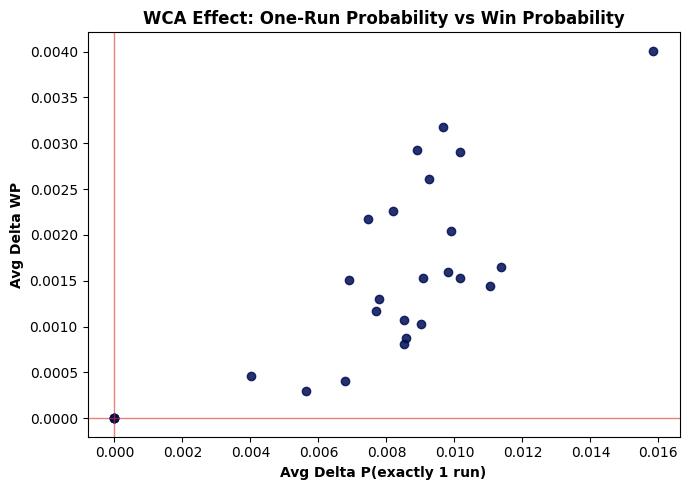

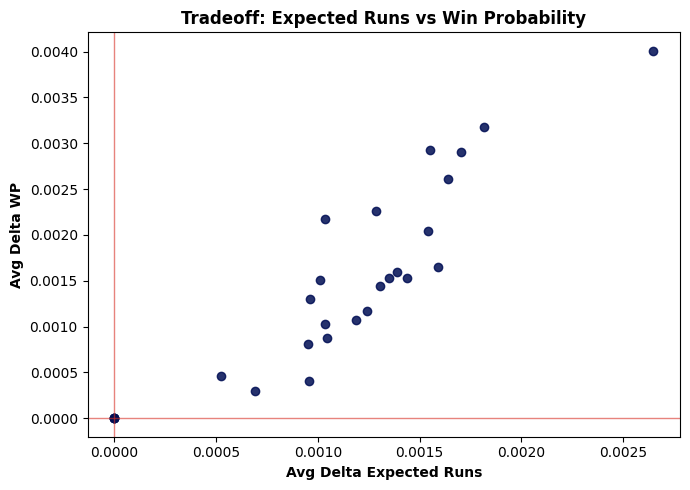

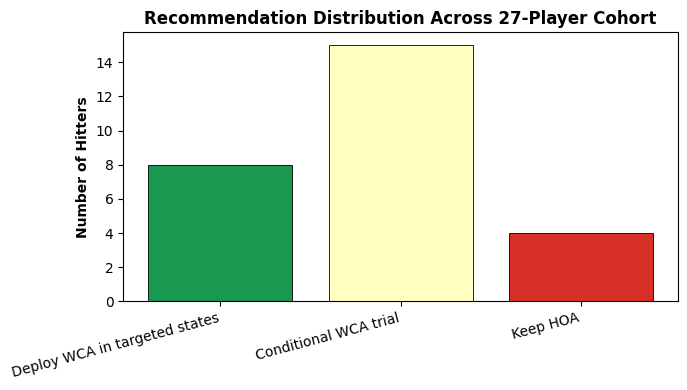

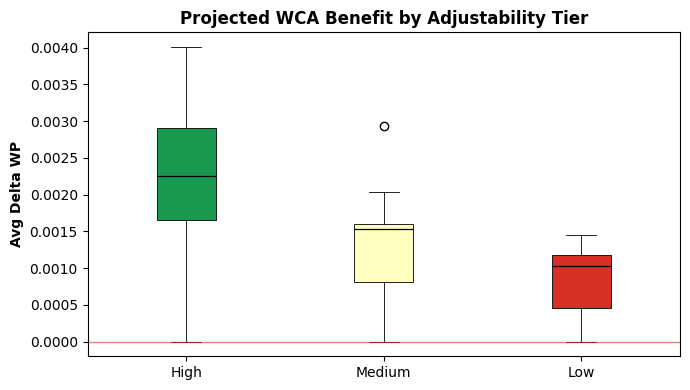

DONE. Outputs saved to: /Users/zacharylevitan/Documents/School_Code_Stuff/Arizona/SABR26/Simulations/output/decision_framework


In [17]:
# Cell 8: Final recommendation + extra visualizations (updated styling)

final_reco = best_cfg_per_hitter.merge(adj, on="player_name", how="left")
final_reco["recommendation"] = np.where(
    (final_reco["avg_delta_wp"] > 0) & (final_reco["adjustability_tier"] == "High"),
    "Deploy WCA in targeted states",
    np.where(final_reco["avg_delta_wp"] > 0, "Conditional WCA trial", "Keep HOA")
)
final_reco = final_reco.sort_values("avg_delta_wp", ascending=False)
final_reco.to_csv(OUT_DIR / "final_recommendation_matrix.csv", index=False)

SCATTER_COLOR = "#000E54"

# 1) DeltaP1 vs DeltaWP
plt.figure(figsize=(7,5))
plt.scatter(
    final_reco["avg_delta_p1"], final_reco["avg_delta_wp"],
    color=SCATTER_COLOR,
    alpha=0.85
)
plt.axhline(0, color=CLR_LOW, lw=1, alpha=0.6)
plt.axvline(0, color=CLR_LOW, lw=1, alpha=0.6)
plt.xlabel("Avg Delta P(exactly 1 run)", fontweight="bold")
plt.ylabel("Avg Delta WP", fontweight="bold")
plt.title("WCA Effect: One-Run Probability vs Win Probability", fontweight="bold")
plt.tight_layout()
plt.savefig(OUT_DIR / "viz_scatter_deltap1_vs_deltawp.png", dpi=300)
plt.show()

# 2) DeltaERV vs DeltaWP
plt.figure(figsize=(7,5))
plt.scatter(
    final_reco["avg_delta_erv"], final_reco["avg_delta_wp"],
    color=SCATTER_COLOR,
    alpha=0.85
)
plt.axhline(0, color=CLR_LOW, lw=1, alpha=0.6)
plt.axvline(0, color=CLR_LOW, lw=1, alpha=0.6)
plt.xlabel("Avg Delta Expected Runs", fontweight="bold")
plt.ylabel("Avg Delta WP", fontweight="bold")
plt.title("Tradeoff: Expected Runs vs Win Probability", fontweight="bold")
plt.tight_layout()
plt.savefig(OUT_DIR / "viz_scatter_deltaerv_vs_deltawp.png", dpi=300)
plt.show()

# 3) Recommendation counts (thin black outline)
rec_counts = final_reco["recommendation"].value_counts().reindex(
    ["Deploy WCA in targeted states", "Conditional WCA trial", "Keep HOA"], fill_value=0
)
plt.figure(figsize=(7,4))
plt.bar(
    rec_counts.index, rec_counts.values,
    color=[CLR_HIGH, CLR_MID, CLR_LOW],
    edgecolor="black",
    linewidth=0.6
)
plt.xticks(rotation=15, ha="right")
plt.ylabel("Number of Hitters", fontweight="bold")
plt.title("Recommendation Distribution Across 27-Player Cohort", fontweight="bold")
plt.tight_layout()
plt.savefig(OUT_DIR / "viz_recommendation_counts.png", dpi=300)
plt.show()

# 4) DeltaWP by adjustability tier (boxplot with thin black outlines)
tier_order = ["High","Medium","Low"]
tier_df = final_reco.dropna(subset=["adjustability_tier"]).copy()
data = [tier_df.loc[tier_df["adjustability_tier"] == t, "avg_delta_wp"].dropna().values for t in tier_order]

plt.figure(figsize=(7,4))
bp = plt.boxplot(
    data,
    tick_labels=tier_order,
    patch_artist=True,
    boxprops=dict(edgecolor="black", linewidth=0.6),
    whiskerprops=dict(color="black", linewidth=0.6),
    capprops=dict(color="black", linewidth=0.6),
    medianprops=dict(color="black", linewidth=0.9)
)
for patch, c in zip(bp["boxes"], [CLR_HIGH, CLR_MID, CLR_LOW]):
    patch.set_facecolor(c)

plt.axhline(0, color=CLR_LOW, lw=1, alpha=0.6)
plt.ylabel("Avg Delta WP", fontweight="bold")
plt.title("Projected WCA Benefit by Adjustability Tier", fontweight="bold")
plt.tight_layout()
plt.savefig(OUT_DIR / "viz_box_deltawp_by_adjustability_tier.png", dpi=300)
plt.show()

print("DONE. Outputs saved to:", OUT_DIR)


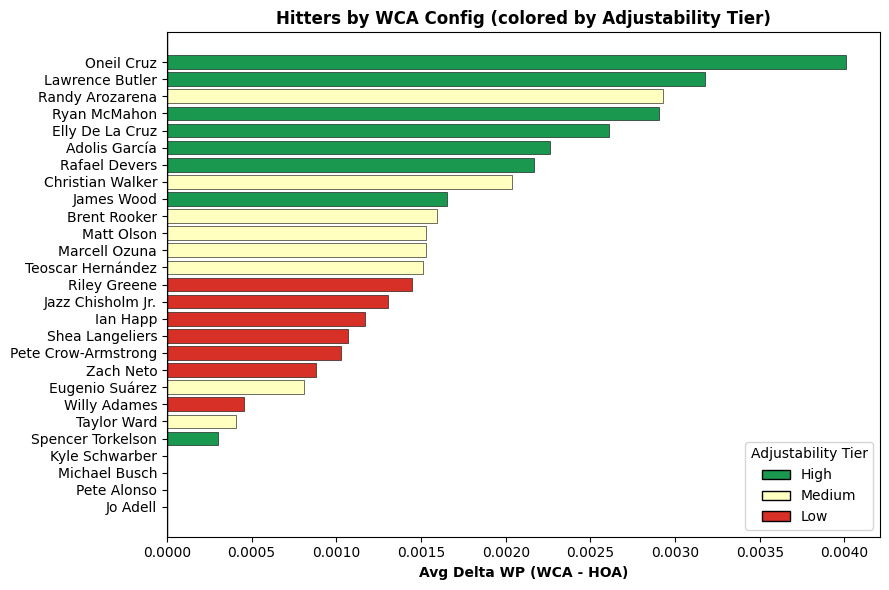

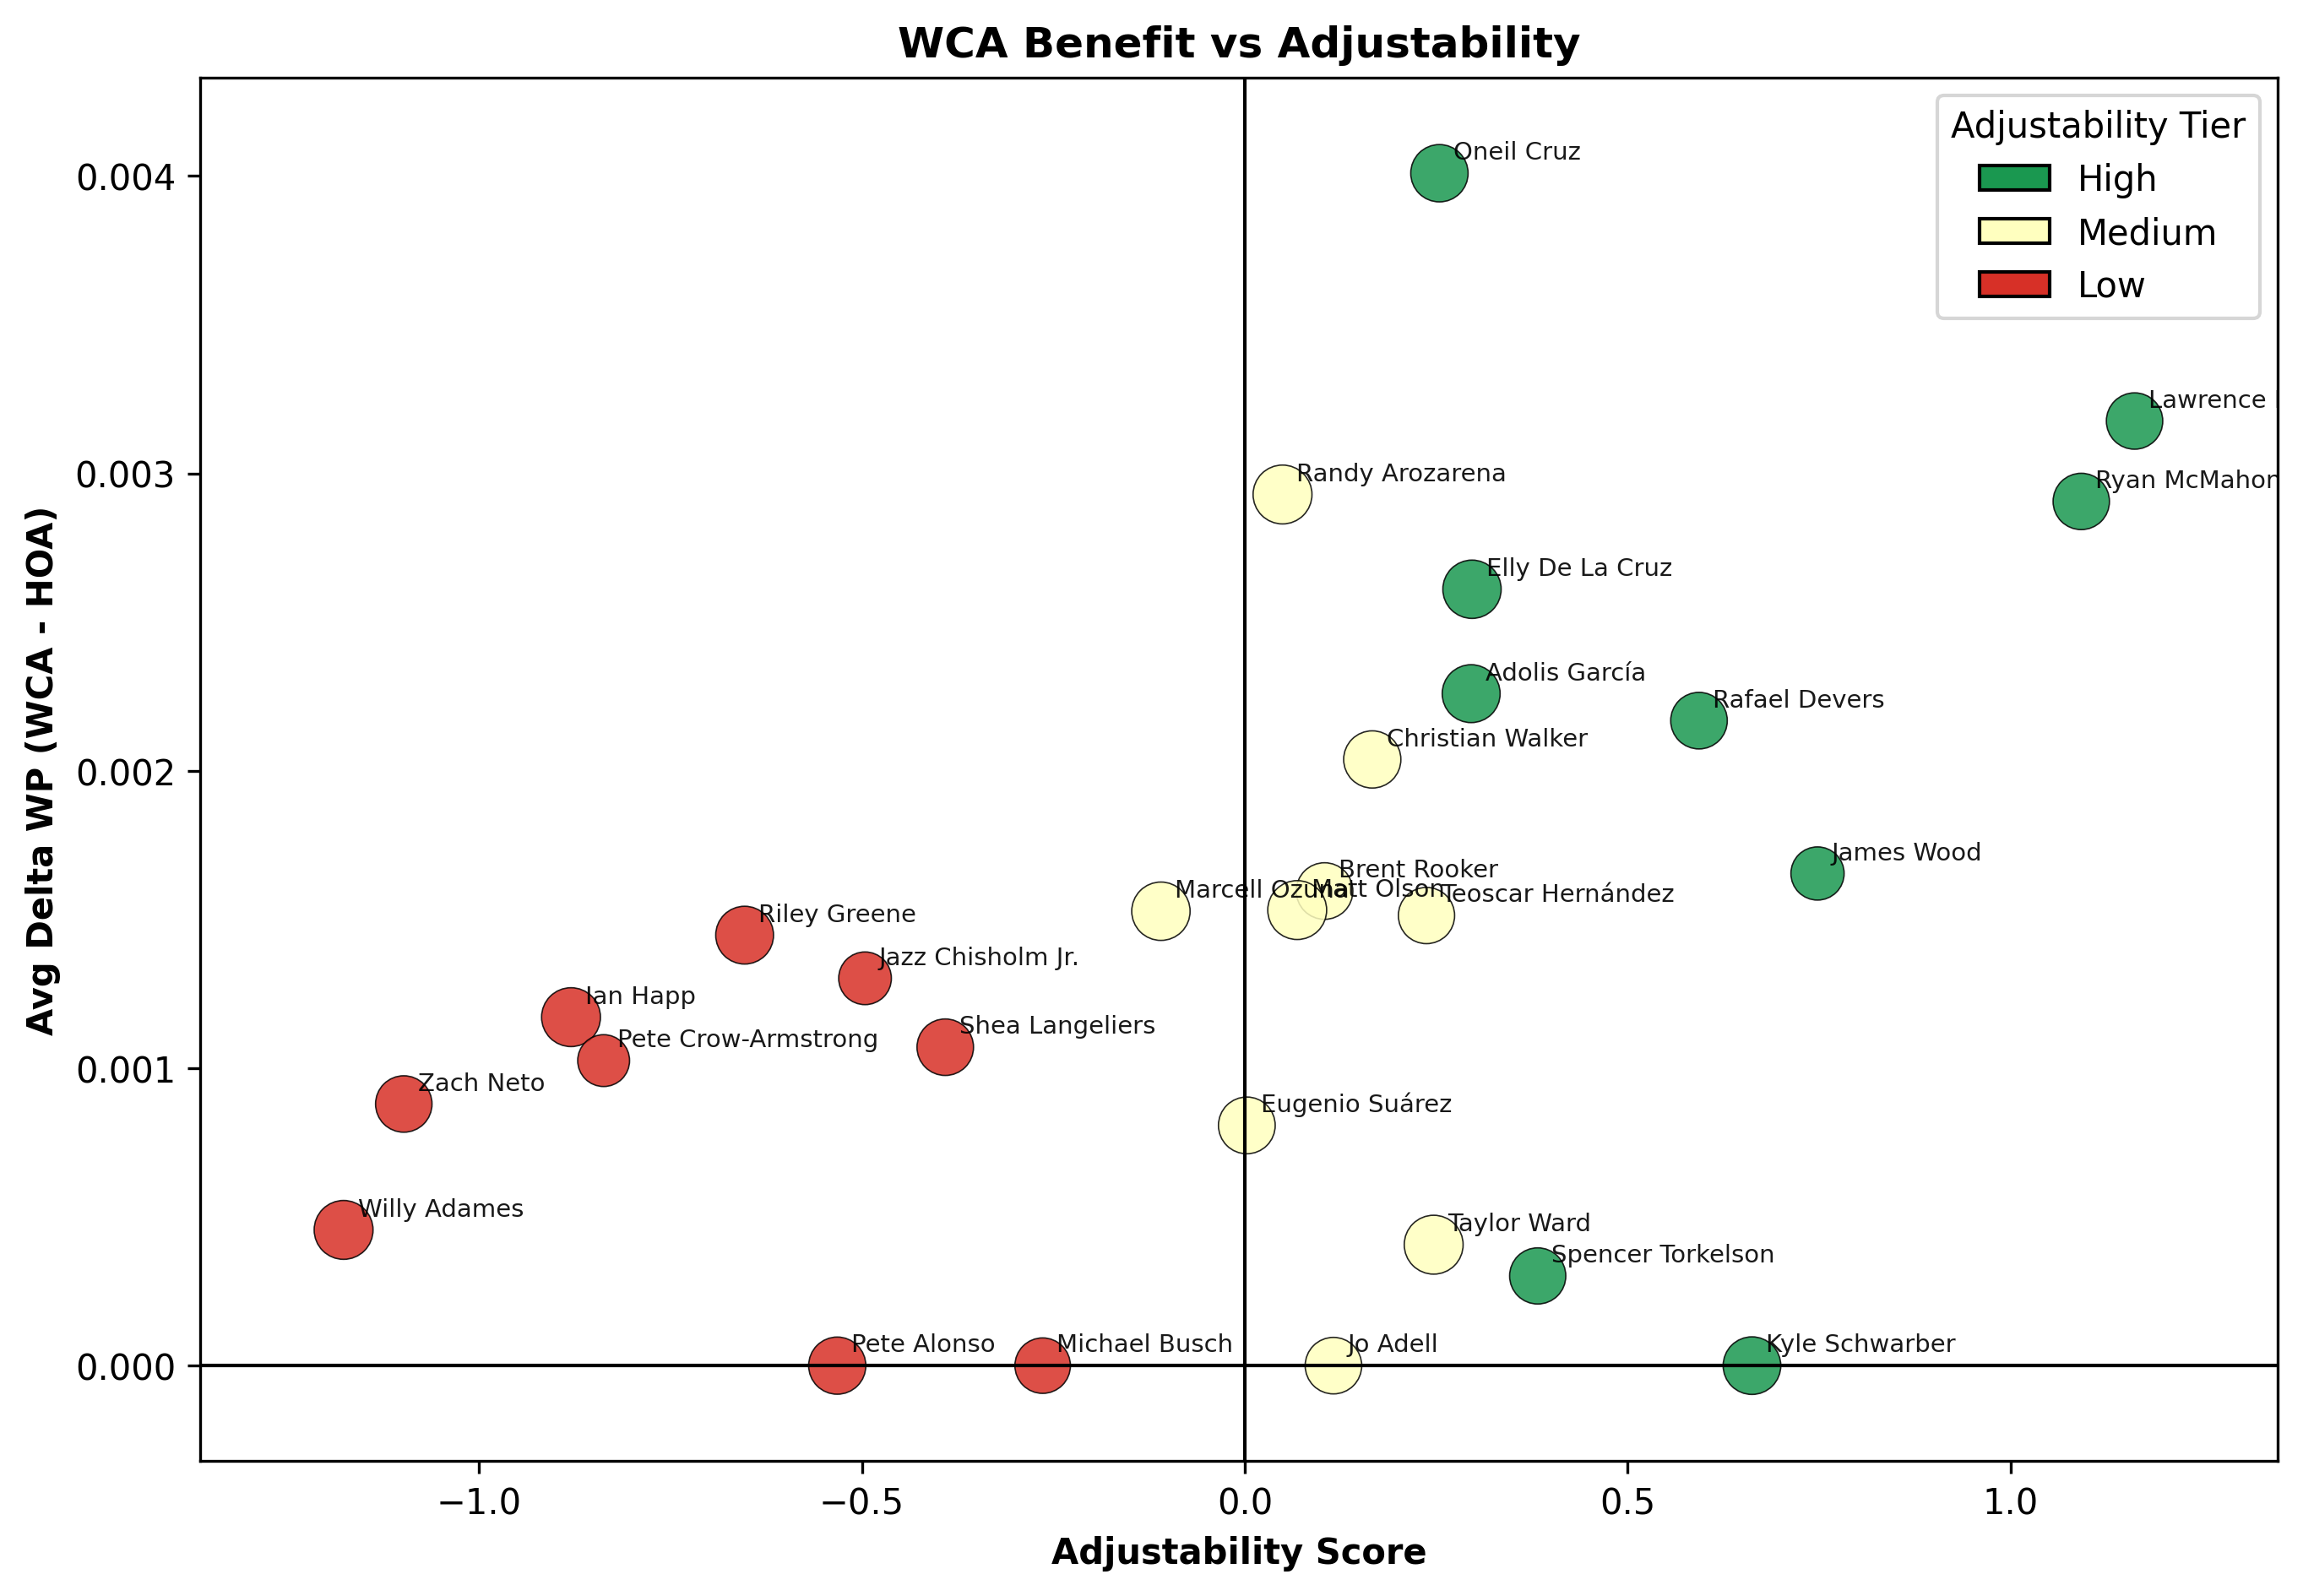

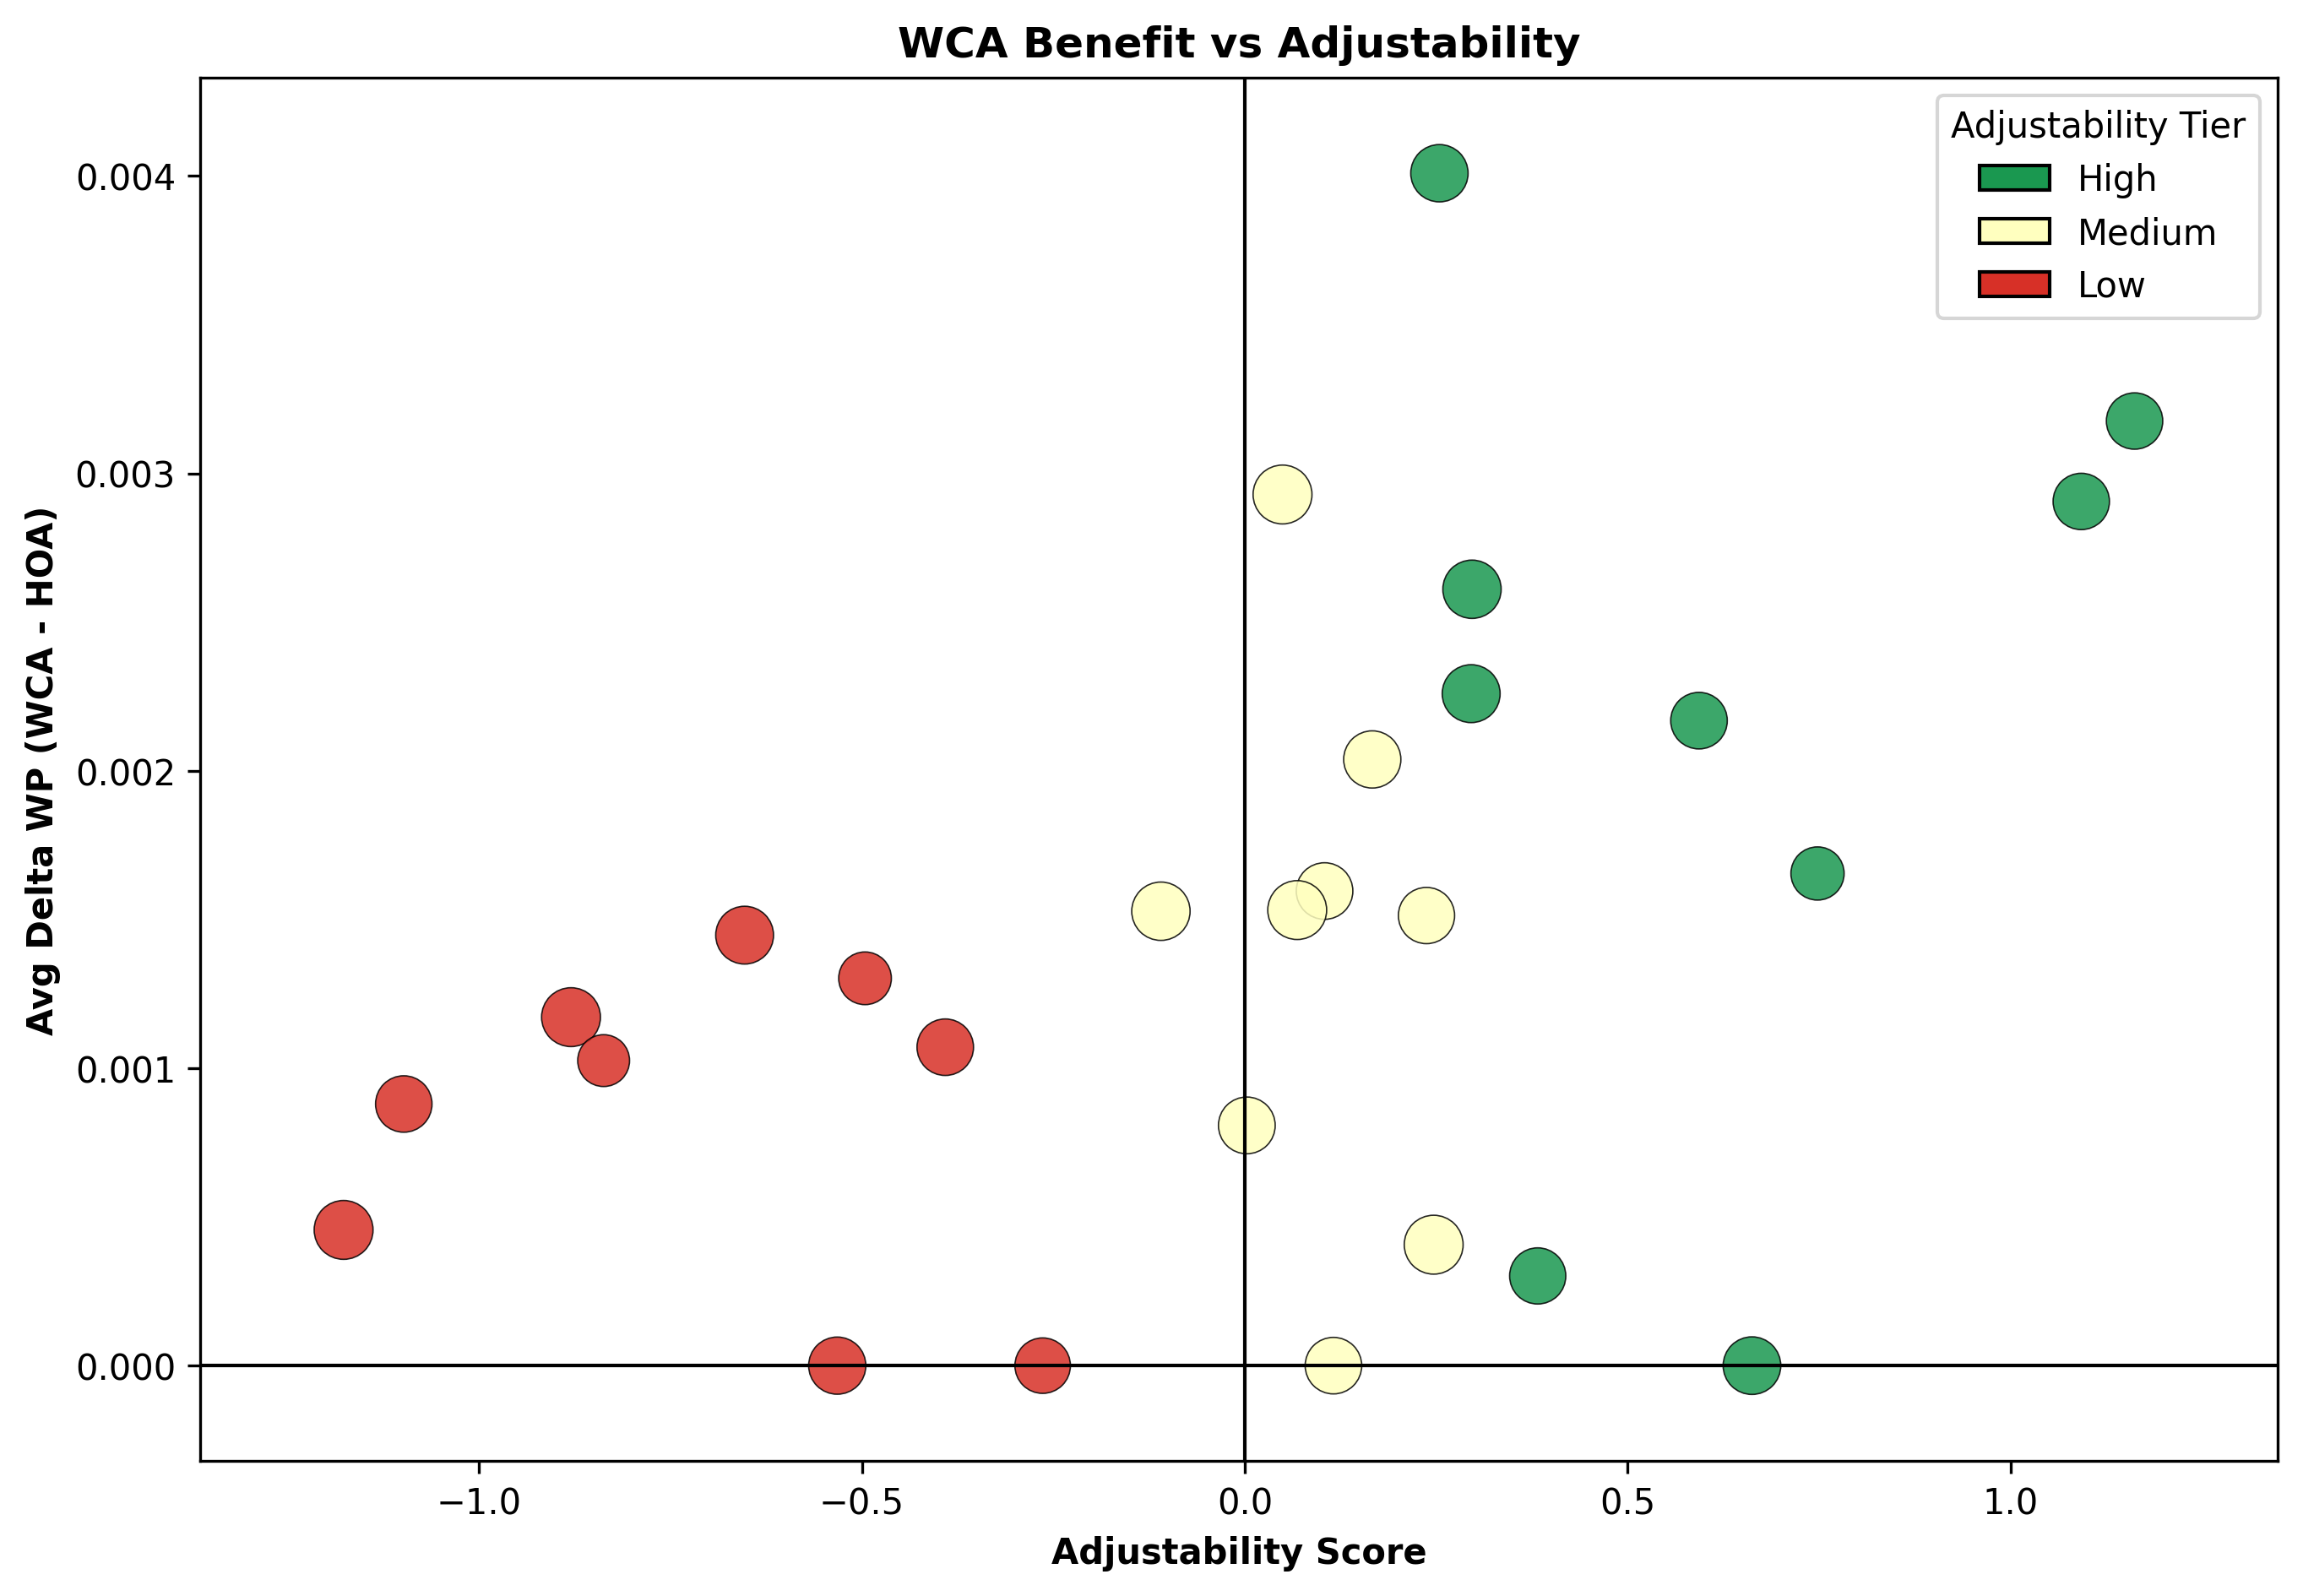

Saved updated visuals:
- /Users/zacharylevitan/Documents/School_Code_Stuff/Arizona/SABR26/Simulations/output/decision_framework/hitter_delta_wp_adjustability.png
- /Users/zacharylevitan/Documents/School_Code_Stuff/Arizona/SABR26/Simulations/output/decision_framework/scatter_wca_vs_adjustability_labeled.png
- /Users/zacharylevitan/Documents/School_Code_Stuff/Arizona/SABR26/Simulations/output/decision_framework/scatter_wca_vs_adjustability_unlabeled.png


In [24]:
# Cell 9: Updated rankings + adjustability-aware visuals

from matplotlib.patches import Patch

# Tier colors (requested palette)
tier_colors = {
    "Low": "#d73027",
    "Medium": "#ffffbf",
    "High": "#1a9850",
}

legend_handles = [
    Patch(facecolor="#1a9850", edgecolor="black", label="High"),
    Patch(facecolor="#ffffbf", edgecolor="black", label="Medium"),
    Patch(facecolor="#d73027", edgecolor="black", label="Low"),
]

# 1) Base ranking from state results
rank_df = state_tax[
    (state_tax["inning"] >= 8) &
    (state_tax["score_diff"].abs() <= 1) &
    (state_tax["base_state"].isin([2,3,4,5,6,7]))
].copy()

hitter_rank_all = (
    rank_df.groupby(["player_name","bat_speed_change_pct","swing_length_change_pct"], as_index=False)
      .agg(
          avg_delta_wp=("delta_wp","mean"),
          avg_delta_p1=("delta_p1","mean"),
          avg_delta_erv=("delta_erv","mean"),
          pct_states_wca_better=("wca_better","mean"),
          n=("wca_better","size")
      )
      .sort_values("avg_delta_wp", ascending=False)
)

best_cfg_per_hitter = (
    hitter_rank_all.sort_values("avg_delta_wp", ascending=False)
    .groupby("player_name", as_index=False)
    .head(1)
    .sort_values("avg_delta_wp", ascending=False)
)

# 2) Merge with adjustability output from Cell 7
viz_df = best_cfg_per_hitter.merge(
    adj[["player_name","reliability","adjustability_score","adjustability_tier"]],
    on="player_name",
    how="left"
)

# Save tables
hitter_rank_all.to_csv(OUT_DIR / "hitter_rank_all_configs.csv", index=False)
viz_df.to_csv(OUT_DIR / "hitter_rank_best_config_with_adjustability.csv", index=False)

# 3) Hitter bar chart (color by adjustability tier)
hitters = viz_df.head(27).sort_values("avg_delta_wp")
bar_colors = [tier_colors.get(t, "#cccccc") for t in hitters["adjustability_tier"]]

plt.figure(figsize=(9,6))
plt.barh(hitters["player_name"], hitters["avg_delta_wp"], color=bar_colors, edgecolor="black", linewidth=0.4)
plt.axvline(0, color="black", linewidth=1)
plt.title("Hitters by WCA Config (colored by Adjustability Tier)", fontweight="bold")
plt.xlabel("Avg Delta WP (WCA - HOA)", fontweight="bold")
plt.legend(handles=legend_handles, title="Adjustability Tier", loc="lower right")
plt.tight_layout()
plt.savefig(OUT_DIR / "hitter_delta_wp_adjustability.png", dpi=300)
plt.show()

# Force identical size/area for labeled and unlabeled versions
scatter_df = viz_df.dropna(subset=["avg_delta_wp","adjustability_score"]).copy()
scatter_colors = [tier_colors.get(t, "#cccccc") for t in scatter_df["adjustability_tier"]]
sizes = 60 + 220 * scatter_df["reliability"].fillna(0)

# Fixed data limits for both charts
x = scatter_df["adjustability_score"].to_numpy()
y = scatter_df["avg_delta_wp"].to_numpy()
x_pad = 0.08 * (x.max() - x.min() if x.max() > x.min() else 1.0)
y_pad = 0.08 * (y.max() - y.min() if y.max() > y.min() else 1.0)
xlim = (x.min() - x_pad, x.max() + x_pad)
ylim = (y.min() - y_pad, y.max() + y_pad)

for show_labels, suffix in [(True, "labeled"), (False, "unlabeled")]:
    fig = plt.figure(figsize=(10, 7), dpi=300)
    ax = fig.add_axes([0.12, 0.12, 0.82, 0.78])

    ax.scatter(
        scatter_df["adjustability_score"],
        scatter_df["avg_delta_wp"],
        c=scatter_colors,
        s=sizes,
        alpha=0.85,
        edgecolors="black",
        linewidths=0.4
    )

    if show_labels:
        for _, r in scatter_df.iterrows():
            ax.annotate(
                r["player_name"],
                (r["adjustability_score"], r["avg_delta_wp"]),
                textcoords="offset points",
                xytext=(4, 4),
                fontsize=7,
                alpha=0.9,
                clip_on=True
            )

    ax.axhline(0, color="black", linewidth=1)
    ax.axvline(0, color="black", linewidth=1)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_title("WCA Benefit vs Adjustability", fontweight="bold")
    ax.set_xlabel("Adjustability Score", fontweight="bold")
    ax.set_ylabel("Avg Delta WP (WCA - HOA)", fontweight="bold")
    ax.legend(handles=legend_handles, title="Adjustability Tier", loc="best")

    fig.savefig(
        OUT_DIR / f"scatter_wca_vs_adjustability_{suffix}.png",
        dpi=300,
        bbox_inches=None,
        pad_inches=0.1
    )
    plt.show()

print("Saved updated visuals:")
print("-", OUT_DIR / "hitter_delta_wp_adjustability.png")
print("-", OUT_DIR / "scatter_wca_vs_adjustability_labeled.png")
print("-", OUT_DIR / "scatter_wca_vs_adjustability_unlabeled.png")
